# Graph Prediction Model
In this notebook, we run through an experiment using UserALE data generated within an instantiation of Superset.  This data reflects four simulated user sessions in which the user performs three tasks within the Video Game Sales example dashboard:

1. Filter the games for Wii, Racing, and Nintendo.
2. Find Mario Kart in the list of games.
3. Determine the difference in global sales between the 3DS game Nintendogs + cats and Wii Sports.

The data of these four sessions is captured in a json file within the data folder entitled `task_example.json`.  In this experiment, we will:

* Experiment with the efficacy of several predictive models to determine which is the best for our objective
* Attempt to plug the `DiGraph` objects resulting from `task_example.json` into the model we choose
* Tune the resulting model to minimize loss and maximize prediction accuracy

**Note: The data utilized in this example was not data collected in any user study.  Rather this data is simulated through developer interactions with the Superset dashboard.**

# Legacy Code:

Generates the graph lists and structures that we'll eventually use for reference.

In [55]:
import sys
sys.path.append('../')

import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    data = {}
    for log in raw_data:
        data[distill.getUUID(log)] = log
        
    # Convert clientTime to specified type
    for uid in data:
        log = data[uid]
        client_time = log['clientTime']
        if date_type == "integer":
            log['clientTime'] = distill.epoch_to_datetime(client_time)
        elif date_type == "datetime":
            log['clientTime'] = pd.to_datetime(client_time, unit='ms', origin='unix')

    # Sort
    sorted_data = sorted(data.items(), key=lambda kv: kv[1]['clientTime'])
    sorted_dict = dict(sorted_data)

    return (sorted_data, sorted_dict)

def draw_digraph(segments):
    nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
    edges = distill.pairwiseSeq(segments.get_segment_list())
    
    # Set coloring of graph based on element in Superset dashboard
    color_map = []
    for segment in segments:
        if re.match("Game_Filter\S*", segment.segment_name):
            color_map.append('green')
        else:
            color_map.append('blue')
    
    graph = distill.createDiGraph(nodes, edges)
    nx.draw(graph, node_color=color_map)
    return graph

In [56]:
data_many_session = setup("./data/task_example.json", "datetime")
sorted_dict = data_many_session[1]

# Create segments based on sessionID
segments = distill.Segments()
session_ids = sorted(distill.find_meta_values('sessionID', sorted_dict), key=lambda sessionID: sessionID)
for session_id in session_ids:
    segments.append_segments(distill.generate_collapsing_window_segments(sorted_dict, 'sessionID', [session_id], session_id))
    
# Improve readability of Segment names
for index in range(len(segments)):
    segments[index].segment_name = "Session" + str(index)
    
    
segment_names = [segment.segment_name for segment in segments]
start_end_vals = [segment.start_end_val for segment in segments]
segment_map = distill.write_segment(sorted_dict, segment_names, start_end_vals)

session_0_segments = distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_1_segments = distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_2_segments = distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_3_segments = distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")

session_0_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_1_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_2_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_3_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))

segments.append_segments(session_0_segments)
segments.append_segments(session_1_segments)
segments.append_segments(session_2_segments)
segments.append_segments(session_3_segments)

**Example user-activity graph:**

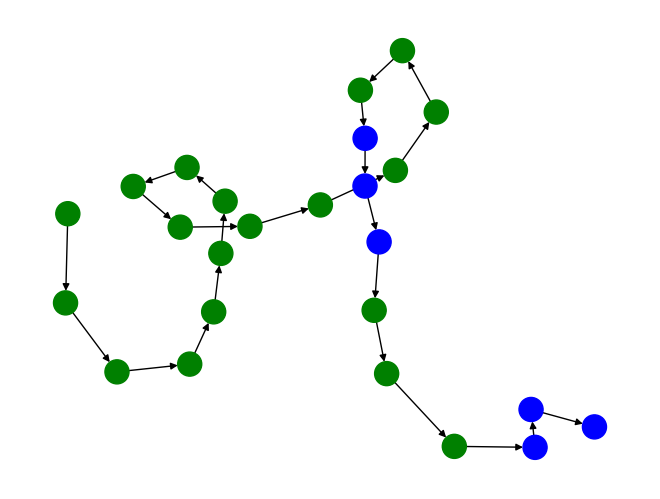

In [57]:
G0 = draw_digraph(session_0_segments)

# GAN Research / Fooling Around:

Source code found at https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

Very basic task: Training a GAN to generate positive integers using vectors of their binary encodings (Ex: 56 is 0111000)

In [58]:
from typing import List
from typing import Tuple
import math

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

**Building the Generator:**

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

**Building the Discriminator**

In [60]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

**Training**

In [61]:
import numpy as np

def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 201):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)
        
        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).unsqueeze(1).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        # Print generator's loss at every 50th step
        if (i % 50)==0 :
          print("STEP ", str(i))
          print(generator_loss)

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        z = torch.zeros(batch_size).unsqueeze(1)
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, z)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

In [62]:
train()

STEP  0
tensor(0.6884, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  50
tensor(0.6701, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  100
tensor(0.6547, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  150
tensor(0.6683, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  200
tensor(0.6806, grad_fn=<BinaryCrossEntropyBackward0>)


So essentially what we'd do for the graphs is, instead of feeding integers, we would feed session data. Feature vectors would represent [div_1, div_2, ..., div_n] with each element denoting whether or not an element was clicked at that segment of the session (vertex of the graph). Only problem is, human-made session data is not so easily generated as it is with random numbers in this example.

**Summary so far:**

So far, I've read:
* (GAN theory) https://www.frontiersin.org/articles/10.3389/fdata.2019.00003/full
* (undirected graphs GAN with tensorflow) https://github.com/hwwang55/GraphGAN (further documentation: https://arxiv.org/pdf/1711.08267.pdf)
* (directed graphs GAN with pytorch) https://github.com/THUDM/GraphSGAN (further documentation: https://arxiv.org/pdf/1809.00130.pdf)

As a result, I have a good idea of the theory and am currently working out how to reverse-engineer the third link which looks most promising. All my notes on this are currently in a word doc.

**Current Problems:**
* A GAN typically requires 50,000-100,000 images/graphs to train on, and we only have 4 graphs in the example
* Having a hard time percieving the third link's input data and how to translate ours to fit its format

**Questions:**
* How accurate would we want our GAN generator to be? (loss-wise)
* Realistically, how many training sessions can we get beyond the 4 that exist in the example json?
* Might be possible to generate the data in a way that doesn't require ML. Maybe through bots or something? Do we want the session data to strictly reflect the behavior of human users?
* What are we looking for in our model? For it to know a typical series of clicks that the average user might generate? In this case, should we consider an ngram-style neural network we could use as a sequence generator (replacing words with segments), instead?

**Input:**
* Stop working on GANs. Too much data is required for training.
* Start working on ngram NN
* Essentially: Predict the next graph in a series of graphs by averaging the past ones
* Purpose: Predicting future user activity based on their past activity. But for now, we will be using the activity of multiple users to predict future activity of the average user
* Aside: If it so happens that our model does not train well, there’s a chance it’s because the data we’re using is flawed. Inform them of this.


# Ngram NN Research / Fooling Around:

Investigating the structure of the segments for good measure (scrap once understood)

In [63]:
segments = session_0_segments
nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
edges = distill.pairwiseSeq(segments.get_segment_list())
print( "UIDS: ", nodes[24].get_segment_uids() )
print( "NAME: ", nodes[24].get_segment_name() )
print( "FIELD NAME: ", nodes[24].get_generate_field_name() )
print( "LENGTH: ", len(nodes) )

UIDS:  ['session_16527363465571652736427217rawmouseover', 'session_16527363465571652736427318rawscroll', 'session_16527363465571652736428683rawmouseover', 'session_16527363465571652736428699rawmouseover', 'session_16527363465571652736428763rawmouseover', 'session_16527363465571652736428909rawwheel', 'session_16527363465571652736428921rawscroll', 'session_16527363465571652736429603rawmouseover', 'session_16527363465571652736429779rawmouseover', 'session_16527363465571652736429835rawmouseover', 'session_16527363465571652736430013rawmouseover', 'session_16527363465571652736430117rawmouseover', 'session_16527363465571652736433401rawmouseover', 'session_16527363465571652736433433rawmouseover', 'session_16527363465571652736433465rawmouseover', 'session_16527363465571652736434235rawmouseover', 'session_16527363465571652736434331rawmouseover', 'session_16527363465571652736436417rawmouseover', 'session_16527363465571652736436433rawmouseover']
NAME:  Games5
FIELD NAME:  path
LENGTH:  25


**Ngram was scrapped in favor of GNNs until further notice.** See https://arxiv.org/pdf/2202.06081.pdf for inspiration.

# GNN Research / Fooling Around:

Read through the following sources/tutorials:

- General GNN overview information: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- More GNN overview information: https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275
- Link Prediction with planetary Cora dataset: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- Graph classification with Heterogeneous data: https://blog.dataiku.com/graph-neural-networks-merging-deep-learning-with-graphs

Ultimately decided on building our prototype from the following tutorial due to the fact that we want a model for Link Prediction of homogeneous graphs with complex node structure (Segment objects): https://blog.dataiku.com/graph-neural-networks-link-prediction-part-two
Even though the data in this link's graph is heterogeneous, the concept application is the same.

Began implementing the Cora planetary dataset code before realizing their data is very heterogeneous and graph structure seems a little more dissimilar to ours. May revisit if it otherwise becomes especially interesting

In [64]:
# %%capture
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [65]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# print(f'Dataset: {dataset}:')
# print('======================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.
# print(data)

**Implementation of the more-relevant heterogeneous graph dataiku tutorial instead:**

Note: The "mean aggregator" as mentioned in https://blog.dataiku.com/graph-neural-networks-link-prediction-part-two may be especially useful

Goal: Predict the rating that a given user is likely to give to the most recent movies. This prediction would then be used to suggest the most relevant movie.

Modeling: The problem can be modeled as a graph with two types of nodes: one representing users and the other movies. A user node is linked to the movie node if the user has rated the movie and is labeled with the rating.

Task: Under this modeling, the problem becomes a link prediction task where the goal is to predict the label (rating) of a link between a user node and a movie node.

Their Original code: https://github.com/linafaik08/graph_neural_networks/blob/main/2_link_prediction.ipynb

My concerns:
- This code depends on user-movie relationships (how do we strip away the user aspect?)
- This code uses a KNN approach (maps movies' feature vectors into a vector space and suggests links between nodes in those K classes from there)
- Link prediction creates a matrix of all possible edges that could exist between all existent nodes

**Our repurposed tutorial code:**

Tutorials proved too far from the problem to offer anything beyond niche understandings of the link prediction process, so I scraped them. May return back if they prove helpful

**From Scratch:**

(Not shown) I tried one version that was very specific to our data, but it started to become a mess with how many transitory methods I had to use to translate the graphs from one state to another and so on. 

Instead, I eventually decided to go very simple and build from there:

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np

# Define the LSTM model class
class GraphLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GraphLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.fc(lstm_out.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

# Define a function to preprocess the data
def preprocess_data(graphs):
    X, y = [], []
    for graph in graphs:
        nodes = list(graph.nodes())
        for i in range(len(nodes) - 1):
            X.append(np.array(nodes[i]))
            y.append(np.array(nodes[i+1]))
    X = np.array(X)
    y = np.array(y)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

# Define the main function to train the model
def train_model(graphs, input_size, hidden_size, output_size, num_epochs):
    # Preprocess the data
    X, y = preprocess_data(graphs)
    print("X: ", X)
    print("y: ", y)

    # Initialize the model, loss function, and optimizer
    model = GraphLSTM(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        hidden = model.init_hidden()
#         loss = torch.zeros(size=(1,), requires_grad=True)
        loss = torch.zeros(1)
        for i in range(X.shape[0]):
            model.zero_grad()
            output, hidden = model(X[i], hidden)
            loss += criterion(output, y[i])
        loss.backward()
        optimizer.step()
        if ((epoch+1)%100)==0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    return model

# Test the model on a sample graph with the most basic data
if __name__ == '__main__':
    # Define a sample graph
    G = nx.DiGraph()
    G.add_edges_from([(1,2), (2,3), (2,4), (3,4), (4,1)])

    # Train the model on a list of graphs
    graphs = [G]
    input_size = 1
    hidden_size = 10
    output_size = 1
    num_epochs = 2000
    model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

    # Test the model by predicting the next most probable node (after 4) in the graph
    input_node = torch.tensor([4], dtype=torch.float32)
    hidden = model.init_hidden()
    output, hidden = model(input_node, hidden)
    predicted_node = round( max(output.detach().numpy()[0]) )
    print(f'Nodes: {G.nodes()}')
    print(f'Output: {output}')
    print(f'Predicted next node: {predicted_node}')

X:  tensor([1., 2., 3.])
y:  tensor([2., 3., 4.])
Epoch 100/2000, Loss: 15.911482810974121
Epoch 200/2000, Loss: 2.4222187995910645
Epoch 300/2000, Loss: 0.6171603202819824
Epoch 400/2000, Loss: 0.4610625207424164
Epoch 500/2000, Loss: 0.37916502356529236
Epoch 600/2000, Loss: 0.30773019790649414
Epoch 700/2000, Loss: 0.2461182028055191
Epoch 800/2000, Loss: 0.19465607404708862
Epoch 900/2000, Loss: 0.15378272533416748
Epoch 1000/2000, Loss: 0.12316189706325531
Epoch 1100/2000, Loss: 0.10104291886091232
Epoch 1200/2000, Loss: 0.08503887057304382
Epoch 1300/2000, Loss: 0.07301736623048782
Epoch 1400/2000, Loss: 0.06337552517652512
Epoch 1500/2000, Loss: 0.05501730740070343
Epoch 1600/2000, Loss: 0.04724908992648125
Epoch 1700/2000, Loss: 0.0396733358502388
Epoch 1800/2000, Loss: 0.032097429037094116
Epoch 1900/2000, Loss: 0.02447284571826458
Epoch 2000/2000, Loss: 0.01692412793636322
Nodes: [1, 2, 3, 4]
Output: tensor([[2.8604]], grad_fn=<AddmmBackward0>)
Predicted next node: 3


**Preliminary Goal Accomplished:** Prove LSTM sequential prediction works with simple float types

Now we'll try the same LSTM on more complicated arbitrary Object types.

First, we'll build an autoencoder that embeds the arbitrary Object types into numeric floats we can plug into an LSTM:

In [103]:
import uuid
from datetime import datetime
import networkx as nx
import itertools
import torch
import torch.nn as nn
import numpy as np

class Obj:
    # constructor function    
    def __init__(self, name, color, weight):
        self.name = name
        self.color = color
        self.weight = weight
        self.id = uuid.uuid4()
        self.creation_time = datetime.now()

    def to_string(self):
        # return f"Object is named \"{self.name}\", has a {self.color} color, and weighs {self.weight}lbs with a UUID of {self.id} created at {self.creation_time}."
        return f"\"{self.name}\" created at {self.creation_time}."
    
    def to_array(self):
        # First problem was it was attempting to convert strings to floats
        # Second problem is there is no 5th elem
        # Third problem is UUID translation
        # No more problems
        return [float(self.weight), float(self.id.time), float(self.id.clock_seq), 
                float(self.id.node), float(self.creation_time.timestamp())]

    @staticmethod
    def from_array(arr):
        print("DECODED ARRAY: ", arr)
        weight = arr[0]
        
#         print("ID_TIME: ", arr[1])
        id_time = int(arr[1])
#         print("ID_TIME: ", id_time)
        id_clock_seq = int(arr[2])
#         print("ID_CLOCK_SEQ: ", id_clock_seq)
        id_node = int(arr[3])
#         print("ID_NODE: ", id_node)
        #First 32 bits of UUID
        time_low = id_time & 0xFFFFFFFF
#         print("TIME_LOW: ", time_low)
        #Next 16 bits
        time_mid = (id_time >> 32) & 0xFFFF
#         print("TIME_MID: ", time_mid)
        #Next 16 bits
        time_hi_version = (id_time >> 48) & 0x0FFF
#         print("TIME_HI_VERSION: ", time_hi_version)
        #Next 8 bits
        clock_seq_hi_variant = (id_clock_seq >> 8) & 0xFF
#         print("CLOCK_SEQ_HI_VARIANT: ", clock_seq_hi_variant)
        #Next 8 bits
        clock_seq_low = id_clock_seq & 0xFF
#         print("CLOCK_SEQ_LOW: ", clock_seq_low)
        #Last 48 bits
        node = id_node.to_bytes(6, byteorder='big')
        fields = (time_low, time_mid, time_hi_version, clock_seq_hi_variant, clock_seq_low, int.from_bytes(node, byteorder='big'))
        
        timestamp = int(arr[4].item())
        creation_time = datetime.fromtimestamp(timestamp)
        
        obj = Obj("", "", weight) #Empty strings are used in place of None types for name/color
        obj.id = uuid.UUID(fields=fields)
        obj.creation_time = creation_time
        return obj

class ObjAutoencoder(nn.Module):
    def __init__(self, encoding_dim): #HERE IS THE PROBLEM
        super().__init__()
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(5, 2 * encoding_dim),
            nn.ReLU(),
            nn.Linear(2 * encoding_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 2 * encoding_dim),
            nn.ReLU(),
            nn.Linear(2 * encoding_dim, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train(self, objs, epochs=100, batch_size=32):
        x_train = torch.tensor([obj.to_array() for obj in objs], dtype=torch.float32)
        print("TRAINING DATA: ", x_train)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(epochs):
            for i in range(0, x_train.shape[0], batch_size):
                batch = x_train[i:i+batch_size]
                optimizer.zero_grad()
                outputs = self.forward(batch)
                loss = loss_fn(outputs, batch)
                loss.backward()
                optimizer.step()

    def encode(self, obj):
        a = obj.to_array()
        print("OBJ ARRAY: ", a)
        x = torch.tensor(a, dtype=torch.float32)
        print("OBJ FLOAT TENSOR: ", x) 
        encoded = self.encoder(x)
        return encoded.detach().numpy()

    def decode(self, encoded):
        decoded = self.decoder(torch.tensor(encoded, dtype=torch.float32))
        print("DECODED FLOAT TENSOR: ", decoded) #Why is decoded translation so poor? Not enough data?
        return Obj.from_array(decoded.detach().numpy())

# Example usage
objs = [Obj("apple", "red", 0.2), Obj("banana", "yellow", 0.3), Obj("orange", "orange", 0.4), Obj("thimble", "silver", 0.01)]
autoencoder = ObjAutoencoder(encoding_dim=1)
autoencoder.train(objs)

# Encode an object to a float
t = objs[0]
print("TEST OBJECT: ", "name: ", t.name, "color: ", t.color, "weight: ", t.weight,"id: ", t.id, "creation time: ", t.creation_time)
encoded = autoencoder.encode(t)
print("ENCODED: ", encoded)

# Decode a float to an object
decoded = autoencoder.decode(encoded)
print("DECODED OBJ: ", "name: ", decoded.name, "color: ", decoded.color, "weight: ", decoded.weight,"id: ", decoded.id, "creation time: ", decoded.creation_time)

TRAINING DATA:  tensor([[2.0000e-01, 9.9288e+17, 1.0940e+04, 1.7524e+14, 1.6803e+09],
        [3.0000e-01, 1.0802e+18, 6.7800e+03, 1.3068e+14, 1.6803e+09],
        [4.0000e-01, 7.8197e+15, 1.1960e+03, 2.5959e+14, 1.6803e+09],
        [1.0000e-02, 3.2056e+17, 1.2872e+04, 1.4478e+14, 1.6803e+09]])
TEST OBJECT:  name:  apple color:  red weight:  0.2 id:  1a6fcba6-6c08-4dc7-aabc-9f610d451959 creation time:  2023-03-31 15:51:44.090629
OBJ ARRAY:  [0.2, 9.928810249175561e+17, 10940.0, 175239183276377.0, 1680292304.090629]
OBJ FLOAT TENSOR:  tensor([2.0000e-01, 9.9288e+17, 1.0940e+04, 1.7524e+14, 1.6803e+09])
ENCODED:  [9.0159945e+16]
DECODED FLOAT TENSOR:  tensor([0., 1., 0., 0., 0.], grad_fn=<SigmoidBackward0>)
DECODED ARRAY:  [0. 1. 0. 0. 0.]
DECODED OBJ:  name:   color:   weight:  0.0 id:  00000001-0000-0000-0000-000000000000 creation time:  1969-12-31 19:00:00


**Problem:** Currently cannot use/predict string types and data integrity (uuid and datetimes) is lost in translation. Maybe the integrity is lost because of the autoencoder structure? Or maybe this has to do with not having enough training data? Let's investigate!

Next, we plug a graph of embedded floats into our LSTM as training data to generate the next likely Object type in the sequence:

In [106]:
# Test the model on a sample graph with the most basic data

# Sort the list of objects according to each object's creation time
objs.sort(key=lambda x: x.creation_time, reverse=True)
# For each object, append its numeric encoding to the list of encoded_objects
encoded_objs = []
for o in objs:
    e = autoencoder.encode(o)
    encoded_objs.append(e[0]) #Accessing first element for float value, try just "e", too
# Define a sample graph with our embedded objects
G = nx.DiGraph()
G.add_edges_from([(encoded_objs[0],encoded_objs[1]), (encoded_objs[1],encoded_objs[2]), (encoded_objs[1],encoded_objs[3]), 
                  (encoded_objs[2],encoded_objs[3]), (encoded_objs[3],encoded_objs[0])])

# Train the model on a list of graphs (just one for now, becuase generating so many is annoying)
graphs = [G]
input_size = 1
hidden_size = 10
output_size = 1
num_epochs = 2000
model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

# Test the model by predicting the next most probable node (after the most recently created obj) in the graph
input_node = torch.tensor([encoded_objs[3]], dtype=torch.float32)
hidden = model.init_hidden()
output, hidden = model(input_node, hidden)
print(f'Nodes: {G.nodes()}')
print(f'Output: {output}')
decoded = autoencoder.decode(output[0])
print('Decoded Output: ', "name: ", decoded.name, "color: ", decoded.color, "weight: ", decoded.weight,"id: ", decoded.id, "creation time: ", decoded.creation_time)

OBJ ARRAY:  [0.2, 9.928810249175561e+17, 10940.0, 175239183276377.0, 1680292304.090629]
OBJ FLOAT TENSOR:  tensor([2.0000e-01, 9.9288e+17, 1.0940e+04, 1.7524e+14, 1.6803e+09])
OBJ ARRAY:  [0.3, 1.08023546804038e+18, 6780.0, 130680203930924.0, 1680292304.090629]
OBJ FLOAT TENSOR:  tensor([3.0000e-01, 1.0802e+18, 6.7800e+03, 1.3068e+14, 1.6803e+09])
OBJ ARRAY:  [0.4, 7819746284398064.0, 1196.0, 259593556815855.0, 1680292304.090629]
OBJ FLOAT TENSOR:  tensor([4.0000e-01, 7.8197e+15, 1.1960e+03, 2.5959e+14, 1.6803e+09])
OBJ ARRAY:  [0.01, 3.205604809978208e+17, 12872.0, 144776519464944.0, 1680292304.090629]
OBJ FLOAT TENSOR:  tensor([1.0000e-02, 3.2056e+17, 1.2872e+04, 1.4478e+14, 1.6803e+09])
X:  tensor([9.0160e+16, 9.8087e+16, 7.3177e+14])
y:  tensor([9.8087e+16, 7.3177e+14, 2.9116e+16])
Epoch 100/2000, Loss: 1.0469406227101136e+34
Epoch 200/2000, Loss: 1.0469406227101136e+34
Epoch 300/2000, Loss: 1.0469406227101136e+34
Epoch 400/2000, Loss: 1.0469406227101136e+34
Epoch 500/2000, Loss: 1

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_2808\2832909376.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded = self.decoder(torch.tensor(encoded, dtype=torch.float32))


**Problem:** Our output encodings seem to be leagues away from the embedding values they're trained off of and if embeddings are zero, it doesn't train at all. Maybe this has to do with the LSTM structure (before it trained/outputed simple floats, now it trains/outputs large ones)? Or maybe this has to do with not having enough training data? Let's investigate!

Now we try plugging our G0,G1,G2,G3 graph data in by first, creating an autoencoder for Segment types:

In [ ]:
# Segment objects for reference (NOT MEANT TO BE RUN):

class Segment_Type(Enum):
    CREATE = "create"
    GENERATE = "generate"
    DEADSPACE = "deadspace"
    FIXED_TIME = "fixed_time"
    GENERATE_COLLAPSING_WINDOWS = "generate_collapsing_windows"
    UNION = "union"
    INTERSECTION = "intersection"
    DIFFERENCE = "difference"

class Segment():
    """
    Distill's segmentation package. Allows the user to segment User Ale log data.
    """

    def __init__(self, segment_name="", start_end_val=None, num_logs=0, uids=[]):
        """
        Initializes a Segment object.  This object contains metadata for the associated Segment.
        :param segment_name: Name associated with the segment, defaults to an empty string
        :param start_end_val: A list of tuples (i.e [(start_time, end_time)], where start_time and end_time are Date/Time Objects or integers.  Defaults to a None value.
        :param num_logs: Number of logs in the segment.  Defaults to 0.
        :param uids: A list of strings representing the associated uids of logs within the segment. Defaults to an empty list.
        """

        self.segment_name = segment_name # string
        self.start_end_val = start_end_val # a list of tuples (i.e [(start_time, end_time)], where start_time and end_time are Date/Time Objects or integers.  Defaults to a None value.
        self.num_logs = num_logs # int
        self.uids = uids # list of uuids
        self.generate_field_name = None # string
        self.generate_matched_values = None # list of values
        self.segment_type = None # Enumerated type

In [180]:
import torch
import numpy as np
from enum import Enum

import uuid
from datetime import datetime

class Segment_Type(Enum):
    CREATE = "create"
    GENERATE = "generate"
    DEADSPACE = "deadspace"
    FIXED_TIME = "fixed_time"
    GENERATE_COLLAPSING_WINDOWS = "generate_collapsing_windows"
    UNION = "union"
    INTERSECTION = "intersection"
    DIFFERENCE = "difference"

def string_to_float_ascii_list(s):
    ascii_list = []
    for char in s:
        ascii_list.append(ord(char))
    return ascii_list

def ascii_list_to_string(ascii_list):
    print(ascii_list)
    s = ""
    for ascii_value in ascii_list:
        if ascii_value >= 0 and ascii_value <= 127:
            s += chr(ascii_value)
    return s

def uuid_to_float_list(id):
    lst = [float(id.time), float(id.clock_seq), float(id.node)]
    return lst

def seg_to_array(segment):
    name_lst = string_to_float_ascii_list(segment.segment_name)
    start_end_tup = segment.start_end_val[0]
    segment_array = np.array([[float(start_end_tup[0].timestamp()), float(start_end_tup[1].timestamp()), 
                               float(segment.num_logs)] + name_lst])
    return segment_array

def array_to_seg(arr):
    start, end, num_logs = arr[:3]
    name = ascii_list_to_string(arr[3:])
#     start_end_val = [(datetime.fromtimestamp(start), datetime.fromtimestamp(end))]
    start_end_val = [(0, 0)]
    uids = []
    print("DECODED: ", "name: ", name, "start_end_val: ", start_end_val, "num_logs: ", num_logs, "uids: ", uids)
    seg = Segment(name, start_end_val, num_logs, uids)
    return seg
    
class SegmentAutoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SegmentAutoencoder, self).__init__()
        self.encoder = torch.nn.Linear(input_size, hidden_size)
        self.decoder = torch.nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x

    def train(self, segments, lr=0.1, batch_size=32, num_epochs=100):
        # Convert segments to arrays
        segment_arrays = [seg_to_array(seg) for seg in segments]
        segment_arrays = np.concatenate(segment_arrays, axis=0)

        # Create PyTorch DataLoader
        dataset = torch.utils.data.TensorDataset(torch.Tensor(segment_arrays))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        # Train loop
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch in dataloader:
                optimizer.zero_grad()
                inputs = batch[0]
                outputs = self(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
#             epoch_loss = running_loss / len(segment_arrays)
            epoch_loss = running_loss / len(dataloader.dataset)
            if (epoch+1)%1000 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

            # Call the train() method of the parent class to update the parameters
            super(SegmentAutoencoder, self).train()

    def encode(self, segment):
        # Make segment_name into some function of its ascii numeric values - or word2vec
        # Combine start_end_val datetime tuple element floats as a single float
        # Keep num_logs the same value
        # Convert uids list into floats that combine into a single float
        segment_array = seg_to_array(segment)
#         print("segment_array: ", segment_array)
#         segment_array = np.array([[len(segment.uids), len(segment.segment_name)]])
        with torch.no_grad():
            encoded = self.encoder(torch.Tensor(segment_array))
        return encoded.squeeze().tolist()
    
    def decode(self, encoded):
        # Convert all of the floats from the encoded value(s) back
        encoded = np.array(encoded)
        encoded = encoded.reshape((1, -1))  # Reshape to (1, latent_dim) - dimensionality of the latent space
        with torch.no_grad():
            decoded = self.decoder(torch.Tensor(encoded))
        decoded = [i for i in decoded.squeeze().tolist()]
        seg = array_to_seg(decoded)
        return seg

# Create some Segment objects
segments = []
seg1 = distill.Segment(segment_name="Segment 1", start_end_val=[(datetime.now(), datetime.now())], num_logs=1, uids=["uid1", "uid2", "uid3", "uid4", "uid5"])
seg2 = distill.Segment("Segment 2", [(datetime.now(), datetime.now())], 2, ["uid6", "uid7", "uid8"])
seg3 = distill.Segment("Segment 3", [(datetime.now(), datetime.now())], 3, ["uid9", "uid10", "uid11","uid12"])
seg4 = distill.Segment("Segment 4", [(datetime.now(), datetime.now())], 4, ["uid13", "uid14"])
seg5 = distill.Segment("Segment 5", [(datetime.now(), datetime.now())], 5, ["uid15", "uid16"])
seg6 = distill.Segment("Segment 6", [(datetime.now(), datetime.now())], 6, ["uid17", "uid18", "uid19"])
segments.append(seg1)
segments.append(seg2)
segments.append(seg3)
segments.append(seg4)
segments.append(seg5)
segments.append(seg6)

# Initialize the autoencoder
input_size = 12
hidden_size = 1 #doubles as the encoding dimension
autoencoder = SegmentAutoencoder(input_size, hidden_size)

# Train the autoencoder on the Segment objects
autoencoder.train(segments, num_epochs=10000)

# Convert a Segment object to a float using the trained autoencoder
seg7 = Segment("Segment 7", [(datetime.now(), datetime.now())], 7, ["uid20", "uid21", "uid22"])
encoded = autoencoder.encode(seg7)
print("Encoded Segment 7:", encoded)
decoded = autoencoder.decode(encoded)
print("Decoded Segment 7:", decoded)
print("Decoded Segment 7:", "segment_name: ", decoded.segment_name, "start_end_val: ", decoded.start_end_val, 
      "num_logs: ", decoded.num_logs,"uids: ", decoded.uids, "generate_field_name: ", decoded.generate_field_name, 
      "generate_matched_values: ", decoded.generate_matched_values, "segment_type: ", decoded.segment_type)

Epoch 1000/10000, Loss: 470901760521666560.0000
Epoch 2000/10000, Loss: 470901760521666560.0000
Epoch 3000/10000, Loss: 470901760521666560.0000
Epoch 4000/10000, Loss: 470901760521666560.0000
Epoch 5000/10000, Loss: 470901760521666560.0000
Epoch 6000/10000, Loss: 470901760521666560.0000
Epoch 7000/10000, Loss: 470901760521666560.0000
Epoch 8000/10000, Loss: 470901760521666560.0000
Epoch 9000/10000, Loss: 470901760521666560.0000
Epoch 10000/10000, Loss: 470901760521666560.0000
Encoded Segment 7: -66757396.0
[-61077808.0, -18881196.0, 23270642.0, 30889696.0, -42210172.0, 52457560.0, 3410816.25, 14296680.0, -24459824.0]
DECODED:  name:   start_end_val:  [(0, 0)] num_logs:  -66012020.0 uids:  []
Decoded Segment 7: <__main__.Segment object at 0x0000021E542A7790>
Decoded Segment 7: segment_name:   start_end_val:  [(0, 0)] num_logs:  -66012020.0 uids:  [] generate_field_name:  None generate_matched_values:  None segment_type:  None


In [ ]:
import torch
import numpy as np
from enum import Enum

import uuid
from datetime import datetime

class Segment_Type(Enum):
    CREATE = "create"
    GENERATE = "generate"
    DEADSPACE = "deadspace"
    FIXED_TIME = "fixed_time"
    GENERATE_COLLAPSING_WINDOWS = "generate_collapsing_windows"
    UNION = "union"
    INTERSECTION = "intersection"
    DIFFERENCE = "difference"
    
class Segment():
    """
    Distill's segmentation package. Allows the user to segment User Ale log data.
    """

    def __init__(self, segment_name="", start_end_val=None, num_logs=0, uids=[]):
        """
        Initializes a Segment object.  This object contains metadata for the associated Segment.
        :param segment_name: Name associated with the segment, defaults to an empty string
        :param start_end_val: A list of tuples (i.e [(start_time, end_time)], where start_time and end_time are Date/Time Objects or integers.  Defaults to a None value.
        :param num_logs: Number of logs in the segment.  Defaults to 0.
        :param uids: A list of strings representing the associated uids of logs within the segment. Defaults to an empty list.
        """

        self.segment_name = segment_name # string
        self.start_end_val = start_end_val # a list of tuples (i.e [(start_time, end_time)], where start_time and end_time are Date/Time Objects or integers.  Defaults to a None value.
        self.num_logs = num_logs # int
        self.uids = uids # list of uuids
        self.generate_field_name = None # string
        self.generate_matched_values = None # list of values
        self.segment_type = None # Enumerated type

def string_to_float_ascii_list(s):
    ascii_list = []
    for char in s:
        ascii_list.append(ord(char))
    return ascii_list

def ascii_list_to_string(ascii_list):
    print(ascii_list)
    s = ""
    for ascii_value in ascii_list:
        if ascii_value >= 0 and ascii_value <= 127:
            s += chr(ascii_value)
    return s

def uuid_to_float_list(id):
    lst = [float(id.time), float(id.clock_seq), float(id.node)]
    return lst

def seg_to_array(segment):
    name_lst = string_to_float_ascii_list(segment.segment_name)
    start_end_tup = segment.start_end_val[0]
    segment_array = np.array([[float(start_end_tup[0].timestamp()), float(start_end_tup[1].timestamp()), 
                               float(segment.num_logs)] + name_lst])
    return segment_array

def array_to_seg(arr):
    start, end, num_logs = arr[:3]
    name = ascii_list_to_string(arr[3:])
#     start_end_val = [(datetime.fromtimestamp(start), datetime.fromtimestamp(end))]
    start_end_val = [(0, 0)]
    uids = []
    print("DECODED: ", "name: ", name, "start_end_val: ", start_end_val, "num_logs: ", num_logs, "uids: ", uids)
    seg = Segment(name, start_end_val, num_logs, uids)
    return seg
    
class SegmentAutoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SegmentAutoencoder, self).__init__()
        self.encoder = torch.nn.Linear(input_size, hidden_size)
        self.decoder = torch.nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x

    def train(self, segments, lr=0.1, batch_size=32, num_epochs=100):
        # Convert segments to arrays
        segment_arrays = [seg_to_array(seg) for seg in segments]
        segment_arrays = np.concatenate(segment_arrays, axis=0)

        # Create PyTorch DataLoader
        dataset = torch.utils.data.TensorDataset(torch.Tensor(segment_arrays))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        # Train loop
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch in dataloader:
                optimizer.zero_grad()
                inputs = batch[0]
                outputs = self(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
#             epoch_loss = running_loss / len(segment_arrays)
            epoch_loss = running_loss / len(dataloader.dataset)
            if (epoch+1)%1000 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

            # Call the train() method of the parent class to update the parameters
            super(SegmentAutoencoder, self).train()

    def encode(self, segment):
        # Make segment_name into some function of its ascii numeric values - or word2vec
        # Combine start_end_val datetime tuple element floats as a single float
        # Keep num_logs the same value
        # Convert uids list into floats that combine into a single float
        segment_array = seg_to_array(segment)
#         print("segment_array: ", segment_array)
#         segment_array = np.array([[len(segment.uids), len(segment.segment_name)]])
        with torch.no_grad():
            encoded = self.encoder(torch.Tensor(segment_array))
        return encoded.squeeze().tolist()
    
    def decode(self, encoded):
        # Convert all of the floats from the encoded value(s) back
        encoded = np.array(encoded)
        encoded = encoded.reshape((1, -1))  # Reshape to (1, latent_dim) - dimensionality of the latent space
        with torch.no_grad():
            decoded = self.decoder(torch.Tensor(encoded))
        decoded = [i for i in decoded.squeeze().tolist()]
        seg = array_to_seg(decoded)
        return seg

# Create some Segment objects
segments = []
seg1 = distill.Segment(segment_name="Segment 1", start_end_val=[(datetime.now(), datetime.now())], num_logs=1, uids=["uid1", "uid2", "uid3", "uid4", "uid5"])
seg2 = distill.Segment("Segment 2", [(datetime.now(), datetime.now())], 2, ["uid6", "uid7", "uid8"])
seg3 = distill.Segment("Segment 3", [(datetime.now(), datetime.now())], 3, ["uid9", "uid10", "uid11","uid12"])
seg4 = distill.Segment("Segment 4", [(datetime.now(), datetime.now())], 4, ["uid13", "uid14"])
seg5 = distill.Segment("Segment 5", [(datetime.now(), datetime.now())], 5, ["uid15", "uid16"])
seg6 = distill.Segment("Segment 6", [(datetime.now(), datetime.now())], 6, ["uid17", "uid18", "uid19"])
segments.append(seg1)
segments.append(seg2)
segments.append(seg3)
segments.append(seg4)
segments.append(seg5)
segments.append(seg6)

# Initialize the autoencoder
input_size = 12
hidden_size = 1 #doubles as the encoding dimension
autoencoder = SegmentAutoencoder(input_size, hidden_size)

# Train the autoencoder on the Segment objects
autoencoder.train(segments, num_epochs=10000)

# Convert a Segment object to a float using the trained autoencoder
seg7 = Segment("Segment 7", [(datetime.now(), datetime.now())], 7, ["uid20", "uid21", "uid22"])
encoded = autoencoder.encode(seg7)
print("Encoded Segment 7:", encoded)
decoded = autoencoder.decode(encoded)
print("Decoded Segment 7:", decoded)
print("Decoded Segment 7:", "segment_name: ", decoded.segment_name, "start_end_val: ", decoded.start_end_val, 
      "num_logs: ", decoded.num_logs,"uids: ", decoded.uids, "generate_field_name: ", decoded.generate_field_name, 
      "generate_matched_values: ", decoded.generate_matched_values, "segment_type: ", decoded.segment_type)

In [142]:
# Test the model on a sample graph with the most basic data

# Sort the list of objects according to each object's creation time
segments.sort(key=lambda x: x.start_end_val[0], reverse=True)
# For each object, append its numeric encoding to the list of encoded_objects
encoded_segs = []
for s in segments:
    e = autoencoder.encode(s)
    encoded_segs.append(e) #Accessing first element for float value, try just "e", too
# Define a sample graph with our embedded objects
G = nx.DiGraph()
G.add_edges_from([(encoded_segs[0],encoded_segs[1]), (encoded_segs[1],encoded_segs[2]), (encoded_segs[1],encoded_segs[3]), 
                  (encoded_segs[2],encoded_segs[3]), (encoded_segs[3],encoded_segs[0])])

# Train the model on a list of graphs (just one for now, becuase generating so many is annoying)
graphs = [G]
input_size = 1
hidden_size = 10
output_size = 1
num_epochs = 2000
model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

# Test the model by predicting the next most probable node (after the most recently created obj) in the graph
input_node = torch.tensor([encoded_segs[3]], dtype=torch.float32)
hidden = model.init_hidden()
output, hidden = model(input_node, hidden)
print(f'Nodes: {G.nodes()}')
print(f'Output: {output}')
decoded = autoencoder.decode(output[0].item())
print("Decoded Segment:", "segment_name: ", decoded.segment_name, "start_end_val: ", decoded.start_end_val, 
      "num_logs: ", decoded.num_logs,"uids: ", decoded.uids, "generate_field_name: ", decoded.generate_field_name, 
      "generate_matched_values: ", decoded.generate_matched_values, "segment_type: ", decoded.segment_type)

X:  tensor([-0.1290, -0.0477])
y:  tensor([-0.0477, -0.2104])
Epoch 100/2000, Loss: 0.06411346793174744
Epoch 200/2000, Loss: 0.0007003856007941067
Epoch 300/2000, Loss: 0.00041232482180930674
Epoch 400/2000, Loss: 0.00021235494932625443
Epoch 500/2000, Loss: 9.556979057379067e-05
Epoch 600/2000, Loss: 3.751950498553924e-05
Epoch 700/2000, Loss: 1.2841665011364967e-05
Epoch 800/2000, Loss: 3.833949449472129e-06
Epoch 900/2000, Loss: 9.992822924687061e-07
Epoch 1000/2000, Loss: 2.2732254478796676e-07
Epoch 1100/2000, Loss: 4.505579553892858e-08
Epoch 1200/2000, Loss: 7.750125874395053e-09
Epoch 1300/2000, Loss: 1.1520140397180967e-09
Epoch 1400/2000, Loss: 1.472966193460934e-10
Epoch 1500/2000, Loss: 1.63229429972489e-11
Epoch 1600/2000, Loss: 1.595168441781425e-12
Epoch 1700/2000, Loss: 4.2366110619695974e-13
Epoch 1800/2000, Loss: 1.9473311851925246e-13
Epoch 1900/2000, Loss: 9.237055564881302e-14
Epoch 2000/2000, Loss: 4.440892098500626e-14
Nodes: [-0.12904709577560425, -0.0476831495

**Next objective:** Find a way to translate the segment objects into autoencoded embeddings for training before translating them back into the predicted output segment we need